In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FIXED_NOISE = torch.randn(64, 100, 1, 1, device=DEVICE)

In [10]:
def weights_init(m: nn.Module):
    classname = m.__class__.__name__
    if "Conv" in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif "BatchNorm" in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [11]:
class GeneratorCGAN(nn.Module):
    def __init__(self, nz: int, num_classes: int):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + num_classes, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        y = self.label_emb(labels).unsqueeze(2).unsqueeze(3)  # (N, C,1,1)
        z = torch.cat([z, y], dim=1)
        return self.main(z)

In [12]:
class DiscriminatorCGAN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 7, 1, bias=False)
        self.embed = nn.Embedding(num_classes, 128 * 7 * 7)
    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        h = self.features(x)
        h_flat = self.flatten(h)
        out = self.fc(h_flat)
        proj = torch.sum(self.embed(labels) * h_flat, dim=1, keepdim=True)
        return out + proj

[E1/10] [0/469] D: 37.393 | G: 22.593
[E1/10] [100/469] D: 1.456 | G: 26.256
[E1/10] [200/469] D: 2.147 | G: 22.484
[E1/10] [300/469] D: 2.170 | G: 10.210
[E1/10] [400/469] D: 0.773 | G: 11.464


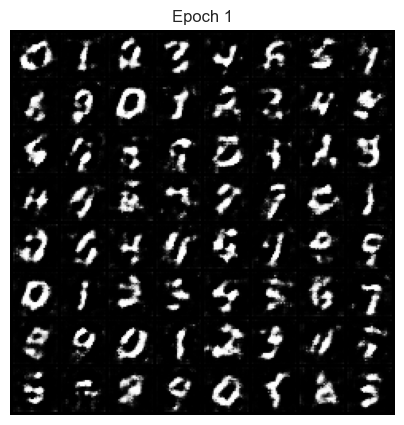

[E2/10] [0/469] D: 2.069 | G: 9.479
[E2/10] [100/469] D: 3.527 | G: 14.099
[E2/10] [200/469] D: 2.577 | G: 9.749
[E2/10] [300/469] D: 2.318 | G: 5.388
[E2/10] [400/469] D: 3.671 | G: 2.856


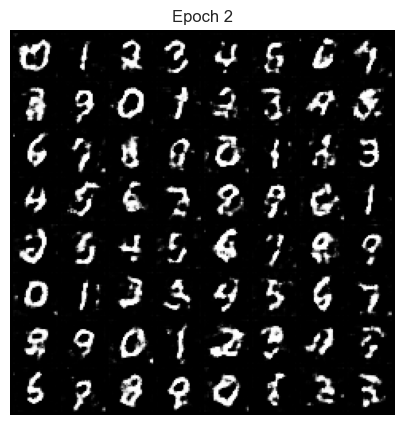

[E3/10] [0/469] D: 1.663 | G: 14.574
[E3/10] [100/469] D: 1.353 | G: 4.269
[E3/10] [200/469] D: 1.934 | G: 4.779
[E3/10] [300/469] D: 1.412 | G: 7.107
[E3/10] [400/469] D: 2.276 | G: 6.139


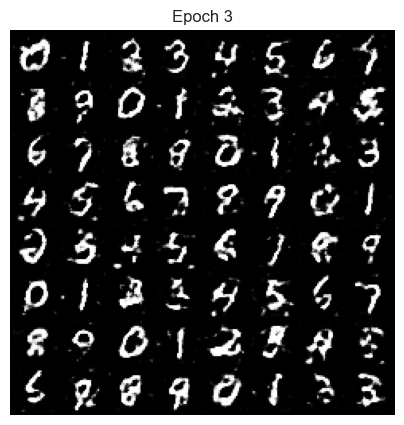

[E4/10] [0/469] D: 3.278 | G: 3.561
[E4/10] [100/469] D: 2.222 | G: 2.297
[E4/10] [200/469] D: 1.549 | G: 4.038
[E4/10] [300/469] D: 1.273 | G: 3.902
[E4/10] [400/469] D: 1.437 | G: 4.116


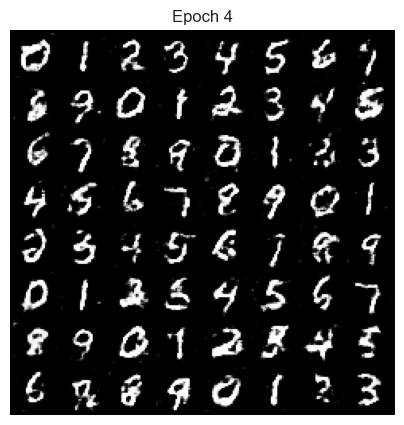

[E5/10] [0/469] D: 1.920 | G: 3.411
[E5/10] [100/469] D: 1.509 | G: 3.797
[E5/10] [200/469] D: 1.484 | G: 2.357
[E5/10] [300/469] D: 2.136 | G: 6.644
[E5/10] [400/469] D: 1.674 | G: 4.002


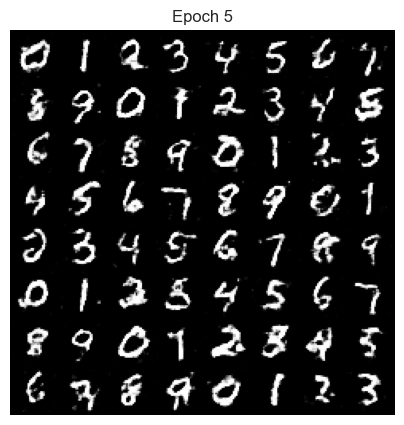

[E6/10] [0/469] D: 1.810 | G: 2.220
[E6/10] [100/469] D: 2.314 | G: 1.057
[E6/10] [200/469] D: 1.924 | G: 2.423
[E6/10] [300/469] D: 2.227 | G: 2.985
[E6/10] [400/469] D: 1.692 | G: 2.130


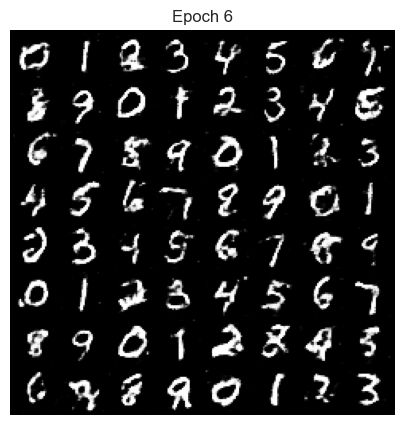

[E7/10] [0/469] D: 1.608 | G: 1.387
[E7/10] [100/469] D: 2.118 | G: 1.615
[E7/10] [200/469] D: 1.775 | G: 1.357
[E7/10] [300/469] D: 2.416 | G: 0.637
[E7/10] [400/469] D: 2.001 | G: 2.592


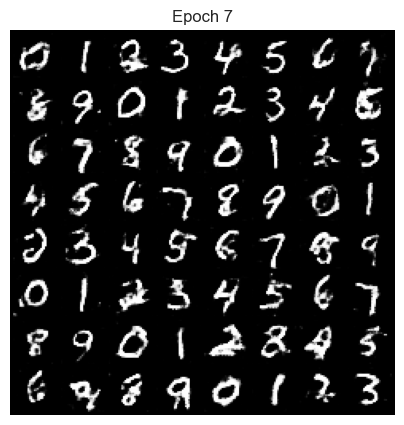

[E8/10] [0/469] D: 1.655 | G: 1.267
[E8/10] [100/469] D: 2.646 | G: 0.865
[E8/10] [200/469] D: 1.583 | G: 2.664
[E8/10] [300/469] D: 1.707 | G: 1.612
[E8/10] [400/469] D: 1.605 | G: 0.872


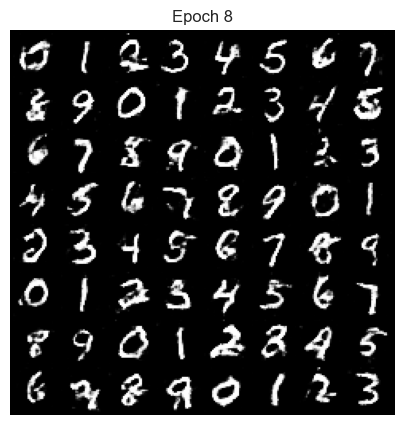

[E9/10] [0/469] D: 2.013 | G: 1.429
[E9/10] [100/469] D: 1.530 | G: 2.730
[E9/10] [200/469] D: 1.780 | G: 1.857
[E9/10] [300/469] D: 2.233 | G: 1.188
[E9/10] [400/469] D: 1.959 | G: 1.418


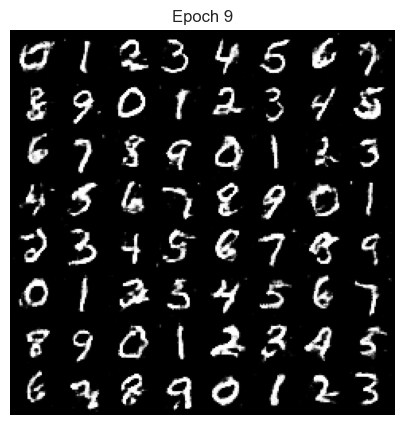

[E10/10] [0/469] D: 1.499 | G: 2.422
[E10/10] [100/469] D: 1.995 | G: 0.605
[E10/10] [200/469] D: 1.890 | G: 0.478
[E10/10] [300/469] D: 1.882 | G: 0.635
[E10/10] [400/469] D: 2.025 | G: 0.433


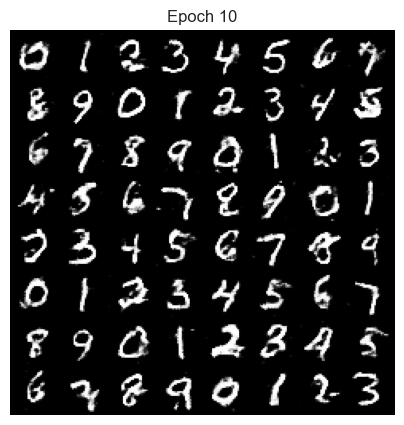

Finished training!


In [15]:
epochs = 10
batch_size = 128
lr = 0.0002
beta1 = 0.5  # Adam β1
nz = 100  # Latent vector size
num_classes = 10  # Digits 0-9


# DataLoader
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Models
netG = GeneratorCGAN(100, num_classes).to(DEVICE)
netD = DiscriminatorCGAN(num_classes).to(DEVICE)
netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()
optD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        bs = imgs.size(0)
        real_lbl = torch.ones(bs, 1, device=DEVICE)
        fake_lbl = torch.zeros(bs, 1, device=DEVICE)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optD.zero_grad()
        o_real = netD(imgs, labels)
        loss_real = criterion(o_real, real_lbl)

        z = torch.randn(bs, 100, 1, 1, device=DEVICE)
        fake_imgs = netG(z, labels)
        o_fake = netD(fake_imgs.detach(), labels)
        loss_fake = criterion(o_fake, fake_lbl)

        d_loss = loss_real + loss_fake
        d_loss.backward()
        optD.step()

        optG.zero_grad()
        o_fake = netD(fake_imgs, labels)
        g_loss = criterion(o_fake, real_lbl)  # fool D
        g_loss.backward()
        optG.step()

        if i % 100 == 0:
            print(f"[E{epoch + 1}/{epochs}] [{i}/{len(loader)}] D: {d_loss.item():.3f} | G: {g_loss.item():.3f}")

    with torch.no_grad():
        lbls = torch.arange(64, device=DEVICE) % num_classes
        fake = netG(FIXED_NOISE, lbls).cpu()
        grid = make_grid(fake, nrow=8, normalize=True)
        grid_np = grid.permute(1, 2, 0).numpy()
        plt.figure(figsize=(5, 5))
        plt.imshow(grid_np, cmap='gray')
        plt.title(f'Epoch {epoch + 1}')
        plt.axis('off')
        plt.show()

print("Finished training!")

In [16]:
import os
import sys
import zipfile


if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve


def download_tinyImg200(path,
                        url='http://cs231n.stanford.edu/tiny-imagenet-200.zip',
                        tarname='tiny-imagenet-200.zip'):
    if not os.path.exists(path):
        os.mkdir(path)

    output_name = os.path.join(path, tarname)
    if os.path.exists(output_name):
        print("Dataset was already downloaded to '{}'. Skip downloading".format(output_name))
    else:
        urlretrieve(url, output_name)
        print("Dataset was downloaded to '{}'".format(output_name))

    print("Extract downloaded dataset to '{}'".format(path))
    with zipfile.ZipFile(output_name, 'r') as f:
        f.extractall(path=path)

In [17]:
data_path = '.'
download_tinyImg200(data_path)

URLError: <urlopen error [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)>